In [ ]:
! pip install tflite-model-maker tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 642 kB 33.2 MB/s 
     |████████████████████████████████| 596 kB 52.8 MB/s 
     |████████████████████████████████| 237 kB 66.1 MB/s 
     |████████████████████████████████| 3.4 MB 61.8 MB/s 
     |████████████████████████████████| 11.2 MB 59.1 MB/s 
     |████████████████████████████████| 87 kB 8.5 MB/s 
     |████████████████████████████████| 1.2 MB 65.2 MB/s 
     |████████████████████████████████| 1.1 MB 66.1 MB/s 
     |████████████████████████████████| 42.5 MB 1.7 MB/s 
     |████████████████████████████████| 6.4 MB 62.5 MB/s 
     |████████████████████████████████| 840 kB 59.0 MB/s 
     |████████████████████████████████| 77 kB 8.2 MB/s 
     |████████████████████████████████| 120 kB 76.0 MB/s 
     |████████████████████████████████| 25.3 MB 1.4 MB/s 
     |████████████████████████████████| 99 kB 11.9 MB/s 
     |█████████████████████████████

In [ ]:
!sudo apt-get install libportaudio2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 0s (454 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


In [ ]:
import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import glob
import random

from IPython.display import Audio, Image
from scipy.io import wavfile

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

TensorFlow Version: 2.8.2
Model Maker Version: 0.4.0


In [ ]:
spec = audio_classifier.YamNetSpec(
    keep_yamnet_and_custom_heads=False,
    frame_step=3 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH,
    frame_length=6 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH)

INFO:tensorflow:Checkpoints are stored in /tmp/tmp7uoh7y1u


In [ ]:
data_dir='/content/drive/MyDrive/Stethoscope/Dataset_2/Combined/Dataset_separated'

In [ ]:
data = audio_classifier.DataLoader.from_folder(
    spec,data_dir, cache=True)

In [ ]:
train_data, val_data = data.split(0.8)

In [ ]:
validation_data,test_data=val_data.split(0.5)

In [ ]:
batch_size = 128
epochs = 150

print('Training the model')
model = audio_classifier.create(
    train_data,
    spec,
    validation_data,
    batch_size=batch_size,
    epochs=epochs)

Training the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 classification_head (Dense)  (None, 2)                2050      
                                                                 
Total params: 2,050
Trainable params: 2,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
156/156 [==============================] - 2776s 17s/step - loss: 0.4921 - acc: 0.7487 - val_loss: 0.4097 - val_acc: 0.8452
Epoch 2/150
156/156 [==============================] - 2s 15ms/step - loss: 0.4029 - acc: 0.8217 - val_loss: 0.3644 - val_acc: 0.8652
Epoch 3/150
156/156 [==============================] - 2s 14ms/step - loss: 0.3733 - acc: 0.8367 - val_loss: 0.3464 - val_acc: 0.8726
Epoch 4/150
156/156 [==============================] - 2s 15ms/step - loss: 0.3584 - acc: 0.8480 - val_loss: 0.3347 - val_acc: 0.8789
Epoch 5/150
156/156 [====

In [ ]:
print('Evaluating the model')
model.evaluate(test_data)

Evaluating the model
77/77 [==============================] - 275s 4s/step - loss: 0.3082 - acc: 0.8741


[0.3082316815853119, 0.8740860819816589]

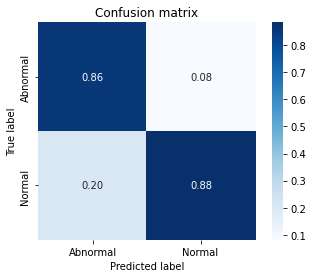

In [ ]:
def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  axis_labels = test_labels
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

confusion_matrix = model.confusion_matrix(test_data)
show_confusion_matrix(confusion_matrix.numpy(), test_data.index_to_label)

In [ ]:
serving_model = model.create_serving_model()

print(f'Model\'s input shape and type: {serving_model.inputs}')
print(f'Model\'s output shape and type: {serving_model.outputs}')

In [ ]:
random_audio='/content/drive/MyDrive/Stethoscope/Dataset_2/Combined/Dataset_separated/Normal /a0007.wav'

In [ ]:
sample_rate, audio_data = wavfile.read(random_audio, 'rb')

audio_data = np.array(audio_data) / tf.int16.max
input_size = serving_model.input_shape[1]

splitted_audio_data = tf.signal.frame(audio_data, input_size, input_size, pad_end=True, pad_value=0)

print(f'Test audio path: {random_audio}')
print(f'Original size of the audio data: {len(audio_data)}')
print(f'Number of windows for inference: {len(splitted_audio_data)}')

In [ ]:
print(random_audio)

results = []
print('Result of the window ith:  your model class -> score,  (spec class -> score)')
for i, data in enumerate(splitted_audio_data):
  yamnet_output, inference = serving_model(data)
  results.append(inference[0].numpy())
  result_index = tf.argmax(inference[0])
  spec_result_index = tf.argmax(yamnet_output[0])
  t = spec._yamnet_labels()[spec_result_index]
  result_str = f'Result of the window {i}: ' \
  f'\t{test_data.index_to_label[result_index]} -> {inference[0][result_index].numpy():.3f}, ' \
  f'\t({spec._yamnet_labels()[spec_result_index]} -> {yamnet_output[0][spec_result_index]:.3f})'
  print(result_str)


results_np = np.array(results)
mean_results = results_np.mean(axis=0)
result_index = mean_results.argmax()
print(f'Mean result: {test_data.index_to_label[result_index]} -> {mean_results[result_index]}')

In [ ]:
models_path = '/content/drive/MyDrive/Stethoscope'
print(f'Exporing the TFLite model to {models_path}')

model.export(models_path, tflite_filename='my_audio_model.tflite')

Exporing the TFLite model to /content/drive/MyDrive/Stethoscope
INFO:tensorflow:Assets written to: /tmp/tmp4nxxr6xo/assets


INFO:tensorflow:Assets written to: /tmp/tmp4nxxr6xo/assets


INFO:tensorflow:TensorFlow Lite model exported successfully: /content/drive/MyDrive/Stethoscope/my_audio_model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: /content/drive/MyDrive/Stethoscope/my_audio_model.tflite


In [ ]:
model.export(models_path, export_format=[mm.ExportFormat.SAVED_MODEL, mm.ExportFormat.LABEL])

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Stethoscope/saved_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Stethoscope/saved_model/assets


INFO:tensorflow:Saving labels in /content/drive/MyDrive/Stethoscope/labels.txt


INFO:tensorflow:Saving labels in /content/drive/MyDrive/Stethoscope/labels.txt
